In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from config import root_dir
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tcav.utils import writeTensorsName

In [20]:
batch_size = 64
epochs = 3
num_classes = 5
type = 'color' #color or number
train_path = root_dir + 'tcav/dataset/for_train/Colored_mnist/' + type + '/train'
test_path = root_dir + 'tcav/dataset/for_train/Colored_mnist/' + type + '/test'
save_path = root_dir + 'tcav/frozen_models/'
dataset_path = root_dir + 'tcav/dataset/'
save_name = 'mnist_' + type + '_2layers_cnn'
dataset_name = 'colored_mnist_' + type
WIDTH = 200
HEIGHT = 200
input_shape = (WIDTH,HEIGHT,3)

In [21]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, name='conv1'))
model.add(Conv2D(32, (3, 3), activation='relu', name='conv2'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(32, (3, 3), activation='relu', name='conv3'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu', name='conv4'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 198, 198, 16)      448       
_________________________________________________________________
conv2 (Conv2D)               (None, 196, 196, 32)      4640      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1229312)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6146565   
Total params: 6,151,653
Trainable params: 6,151,653
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss='categorical_crossentropy',
               optimizer='sgd',
               metrics=['accuracy'])


# train_datagen = ImageDataGenerator(
#      rescale=1.0 / 255,
#     shear_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True)

train_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical')
    

Found 57480 images belonging to 5 classes.
Found 9980 images belonging to 5 classes.


In [23]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
    )

Epoch 1/3
899/899 [==============================] - 708s 788ms/step - loss: 0.0165 - acc: 0.9967 - val_loss: 0.0017 - val_acc: 0.9999
Epoch 2/3
899/899 [==============================] - 715s 795ms/step - loss: 8.2350e-04 - acc: 0.9999 - val_loss: 0.0013 - val_acc: 0.9999
Epoch 3/3
899/899 [==============================] - 690s 768ms/step - loss: 5.2935e-04 - acc: 0.9999 - val_loss: 0.0012 - val_acc: 0.9999


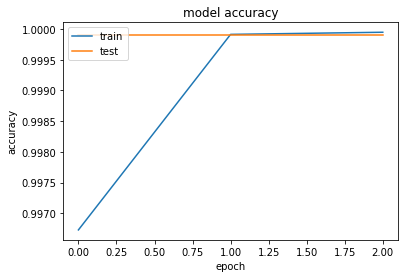

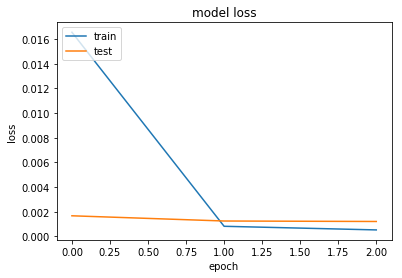

In [24]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
print('epoch {}'.format(epochs))
print('image size {}'.format(WIDTH,HEIGHT))
print('class {}'.format(num_classes))
print('num train data {}'.format(11229))
print('num test data {}'.format(2932))
print('batch_size {}'.format(batch_size))
print('train acc {}'.format(history.history['acc'][-1]))
print('test acc {}'.format(history.history['val_acc'][-1]))

epoch 3
image size 200
class 5
num train data 11229
num test data 2932
batch_size 64
train acc 0.9999477863311768
test acc 0.9998998045921326


In [26]:
# outputのノード名が必要なのでprintして確認する
print(model.output.op.name)
output_node_name = model.output.op.name
#ファイル名を.ckptとしてモデルを保存
saver = tf.train.Saver()
saver.save(K.get_session(), 'frozen_model.ckpt')

dense_1/Softmax


'frozen_model.ckpt'

In [27]:
output_path = save_path + save_name + '.pb'
os.system('python tensorflow/tensorflow/python/tools/freeze_graph.py --input_meta_graph=frozen_model.ckpt.meta --input_checkpoint=frozen_model.ckpt --output_graph={0}  --output_node_names={1} --input_binary=true'.format(output_path,output_node_name))
os.system('rm -rf frozen_model.ckpt*')
os.system('rm checkpoint')

0

In [28]:
output_name_path = output_path[:-3] + '_name'
if os.path.exists(output_name_path) == False:
  writeTensorsName(output_path,output_name_path)

In [29]:
# label保存

with open(dataset_path + dataset_name, mode='w') as f:
  for name in train_generator.class_indices.keys():
    f.write(name + '\n')

In [30]:
output_summary_path = output_path[:-3] + '_summary'
with open(output_summary_path, "w") as fp:
    model.summary(print_fn=lambda x: fp.write(x + "\r\n"))